In [1]:
import os
import itertools

from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd

from utils import list_images
from yunet import YuNet
from sface import SFace

In [2]:
# IMAGES_DIR = "/media/rodrigo/RODRIGO/face_front_faces/"
IMAGES_DIR = "/home/rodrigo/Downloads/lfw_align"
VALID_EXT = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
USE_YUNET = False

In [3]:
weights_path = "./sface/bins/face_recognition_sface_2021dec.onnx"
recognizer = SFace(model_path=weights_path, dis_type=0, backend_id=cv2.dnn.DNN_BACKEND_CUDA,
                   target_id=cv2.dnn.DNN_TARGET_CUDA)

face_detector = YuNet()

In [4]:
idendities = {}
images_hash = {}
for (root_dir, dir_names, filenames) in tqdm(os.walk(IMAGES_DIR)):
    for filename in filenames:

        ext = filename[filename.rfind("."):].lower()

        if VALID_EXT is None or ext.endswith(VALID_EXT):
            image_path = os.path.join(root_dir, filename)
            idenditie = root_dir.split("/")[-1]
            try:
                image = cv2.imread(image_path)
                
                if USE_YUNET:
                    data = face_detector.detect(image)[0][1]
                    face_hash = cv2.normalize(recognizer.infer(image, data), None)
                else:
                    input_sample = cv2.resize(image, (112, 112))
                    face_hash = cv2.normalize(recognizer.infer(input_sample), None)
                images_hash[image_path] = face_hash
            except:
                continue
            if idenditie not in idendities:
                idendities[idenditie] = [image_path]
            else:
                idendities[idenditie].append(image_path)

0it [00:00, ?it/s][ WARN:0@5.055] global /io/opencv/modules/dnn/src/dnn.cpp (1483) setUpNet DNN module was not built with CUDA backend; switching to CPU
5750it [01:29, 63.99it/s] 


In [5]:
positives = []

for key, values in idendities.items():
    
    #print(key)
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            #print(values[i], " and ", values[j])
            positive = []
            positive.append(values[i])
            positive.append(values[j])
            positives.append(positive)

In [6]:
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

In [7]:
samples_list = list(idendities.values())

negatives = []

for i in tqdm(range(0, len(idendities) - 1)):
    for j in range(i+1, len(idendities)):
        #print(samples_list[i], " vs ",samples_list[j]) 
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)
        #print(cross_product)
        
        for cross_sample in cross_product:
            #print(cross_sample[0], " vs ", cross_sample[1])
            negative = []
            negative.append(cross_sample[0])
            negative.append(cross_sample[1])
            negatives.append(negative)


100%|██████████| 5748/5748 [00:54<00:00, 106.05it/s]


In [8]:
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"


In [9]:
df = pd.concat([positives, negatives]).reset_index(drop = True)
instances = df[["file_x", "file_y"]].values.tolist()

In [10]:
distances = []
for x, y in tqdm(instances):    
    face_hash_x = images_hash[x]
    face_hash_y = images_hash[y]
    
    dist = (face_hash_x * face_hash_y).sum()
    distances.append(dist)



100%|██████████| 87549528/87549528 [03:36<00:00, 405046.82it/s]


In [11]:
df["distance"] = distances

In [12]:
# release some memmory
del negatives
del positives
del distances
del instances


In [13]:
# tp_mean = round(df[df.decision == "Yes"].mean().values[0], 4)
# tp_std = round(df[df.decision == "Yes"].std().values[0], 4)

values = df[df.decision == "Yes"].distance.values
tp_mean = values.mean()
tp_mean = round(tp_mean, 4)

tp_std = values.std()
tp_std = round(tp_std, 4)

In [16]:
values = df[df.decision == "No"].distance.values
fp_mean = values.mean()
fp_mean = round(fp_mean, 4)

fp_std = values.std()
fp_std = round(fp_std, 4)

In [17]:
print("Mean of true positives: ", tp_mean)
print("Std of true positives: ", tp_std)
print("Mean of false positives: ", fp_mean)
print("Std of false positives: ", fp_std)

Mean of true positives:  0.6553
Std of true positives:  0.0959
Mean of false positives:  0.09
Std of false positives:  0.0963


In [58]:
# Remember that 2 standard deviation corresponds 95.45% confidence and 3 standard deviation corresponds 99.73% confidence. Let’s set the threshold to 2 sigma.
sigma = 3
threshold = round(fp_mean + sigma * fp_std, 4)
print(threshold)

0.3789


<AxesSubplot:ylabel='Density'>

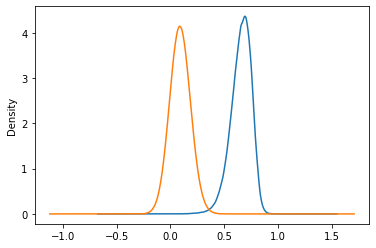

In [14]:
df[df.decision == "Yes"].distance.plot.kde()
df[df.decision == "No"].distance.plot.kde()